# Introducción

In [1]:
import numpy as np
import json
import time
from pathlib import Path
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Descripción del Método

In [2]:
def f(x):
    """Objective function"""
    x_val, y_val = x[0], x[1]
    return -(np.arctan(x_val + y_val + 1) + 
             np.arctan(x_val - y_val + 2) + 
             np.arctan(-x_val - y_val + 3) + 
             np.arctan(-x_val + y_val + 4))

def grad_f(x):
    """Gradient of objective function"""
    x_val, y_val = x[0], x[1]
    u1 = x_val + y_val + 1
    u2 = x_val - y_val + 2
    u3 = -x_val - y_val + 3
    u4 = -x_val + y_val + 4
    
    df_dx = -1/(1 + u1**2) - 1/(1 + u2**2) + 1/(1 + u3**2) + 1/(1 + u4**2)
    df_dy = -1/(1 + u1**2) + 1/(1 + u2**2) + 1/(1 + u3**2) - 1/(1 + u4**2)
    
    return np.array([df_dx, df_dy])

## Resultados

In [3]:
def gradient_descent(x0, learning_rate, tol, max_iter):
    """Gradient Descent optimization"""
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    
    for i in range(max_iter):
        grad = grad_f(x)
        x_new = x - learning_rate * grad
        history.append(x_new.copy())
        
        if np.linalg.norm(x_new - x) < tol:
            return x_new, i + 1, history
        
        x = x_new
    
    return x, max_iter, history

def bfgs_method(x0, tol, max_iter):
    """BFGS Quasi-Newton optimization"""
    history = [np.array(x0)]
    
    def callback(xk):
        history.append(xk.copy())
    
    result = minimize(f, x0, method='BFGS', jac=grad_f, 
                     options={'maxiter': max_iter, 'gtol': tol},
                     callback=callback)
    
    return result.x, result.nit, history

## Análisis

In [4]:
def MakeExperiments():
    """Load configs, run experiments, save results"""
    exp_dir = Path('Experiments')
    results_dir = Path('Results')
    results_dir.mkdir(exist_ok=True)
    
    for exp_file in exp_dir.glob('*.json'):
        with open(exp_file, 'r') as fh:
            configs = json.load(fh)
        
        results = []
        
        for config in configs:
            lr = config['learning_rate']
            tol = config['tol']
            max_iter = config['max_iter']
            x0 = config['x0']
            
            # Gradient Descent
            start = time.time()
            x_gd, iter_gd, hist_gd = gradient_descent(x0, lr, tol, max_iter)
            time_gd = time.time() - start
            
            # BFGS
            start = time.time()
            x_bfgs, iter_bfgs, hist_bfgs = bfgs_method(x0, tol, max_iter)
            time_bfgs = time.time() - start
            results.append({
                'config': config,
                'gradient_descent': {
                    'solution': x_gd.tolist(),
                    'f_value': float(f(x_gd)),
                    'iterations': int(iter_gd),
                    'time': float(time_gd),
                    'gradient_norm': float(np.linalg.norm(grad_f(x_gd))),
                    'path': [pt.tolist() for pt in hist_gd]
                },
                'bfgs': {
                    'solution': x_bfgs.tolist(),
                    'f_value': float(f(x_bfgs)),
                    'iterations': int(iter_bfgs),
                    'time': float(time_bfgs),
                    'gradient_norm': float(np.linalg.norm(grad_f(x_bfgs))),
                    'path': [pt.tolist() for pt in hist_bfgs]
                }
            })
        
        result_file = results_dir / f'results_{exp_file.name}'
        with open(result_file, 'w') as fh:
            json.dump(results, fh, indent=2)
        
        print(f"Results saved to {result_file}")
    
    return results

## Conclusiones

In [5]:
results = MakeExperiments()

Results saved to Results\results_exp1.json


## Visualización de Resultados

In [6]:
print("\n=== COMPARATIVE ANALYSIS ===")
print("\nMethod Comparison:")
print("-" * 80)

for i, result in enumerate(results):
    print(f"\nExperiment {i+1}: x0={result['config']['x0']}, lr={result['config']['learning_rate']}")
    
    gd = result['gradient_descent']
    bfgs = result['bfgs']
    
    print(f"\nGradient Descent:")
    print(f"  Solution: ({gd['solution'][0]:.6f}, {gd['solution'][1]:.6f})")
    print(f"  f(x): {gd['f_value']:.8f}")
    print(f"  Iterations: {gd['iterations']}")
    print(f"  Time: {gd['time']:.6f}s")
    
    print(f"\nBFGS:")
    print(f"  Solution: ({bfgs['solution'][0]:.6f}, {bfgs['solution'][1]:.6f})")
    print(f"  f(x): {bfgs['f_value']:.8f}")
    print(f"  Iterations: {bfgs['iterations']}")
    print(f"  Time: {bfgs['time']:.6f}s")
    
    print(f"\nComparison:")
    print(f"  Iteration ratio (GD/BFGS): {gd['iterations']/bfgs['iterations']:.2f}")
    print(f"  Time ratio (GD/BFGS): {gd['time']/bfgs['time']:.2f}")
    print(f"  f-value difference: {abs(gd['f_value'] - bfgs['f_value']):.2e}")


=== COMPARATIVE ANALYSIS ===

Method Comparison:
--------------------------------------------------------------------------------

Experiment 1: x0=[0, 0], lr=0.1

Gradient Descent:
  Solution: (0.999972, 0.000028)
  f(x): -4.71238898
  Iterations: 399
  Time: 0.011080s

BFGS:
  Solution: (1.000000, -0.000000)
  f(x): -4.71238898
  Iterations: 9
  Time: 0.007736s

Comparison:
  Iteration ratio (GD/BFGS): 44.33
  Time ratio (GD/BFGS): 1.43
  f-value difference: 1.95e-10

Experiment 2: x0=[1, 1], lr=0.05

Gradient Descent:
  Solution: (0.999942, 0.000058)
  f(x): -4.71238898
  Iterations: 744
  Time: 0.018282s

BFGS:
  Solution: (1.000000, 0.000000)
  f(x): -4.71238898
  Iterations: 9
  Time: 0.002209s

Comparison:
  Iteration ratio (GD/BFGS): 82.67
  Time ratio (GD/BFGS): 8.28
  f-value difference: 8.09e-10

Experiment 3: x0=[-1, -1], lr=0.01

Gradient Descent:
  Solution: (0.996212, 0.003782)
  f(x): -4.71238554
  Iterations: 2000
  Time: 0.033414s

BFGS:
  Solution: (0.999998, 0.0000

## Gráficos comparativos de las soluciones encontradas por los algoritmos

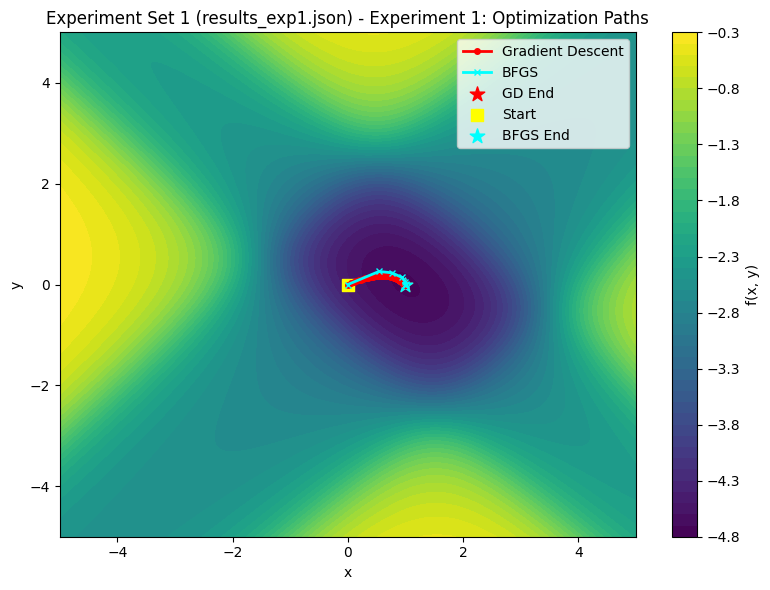

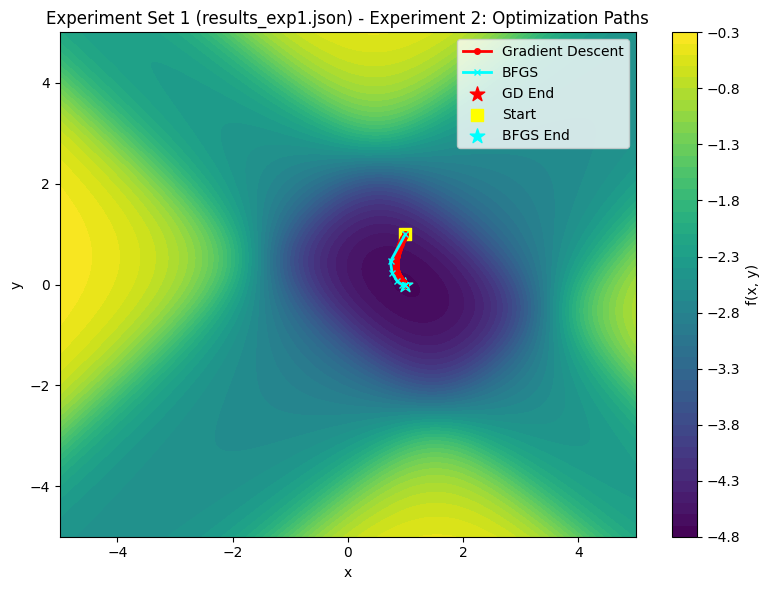

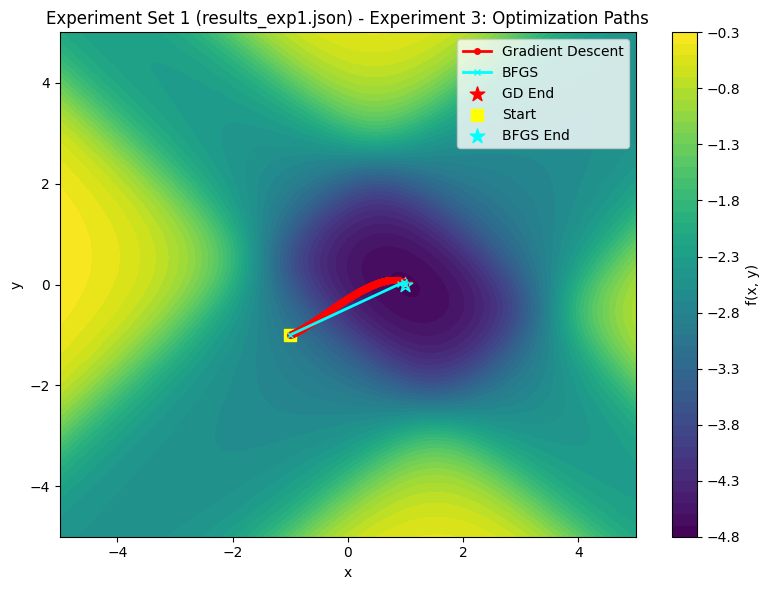

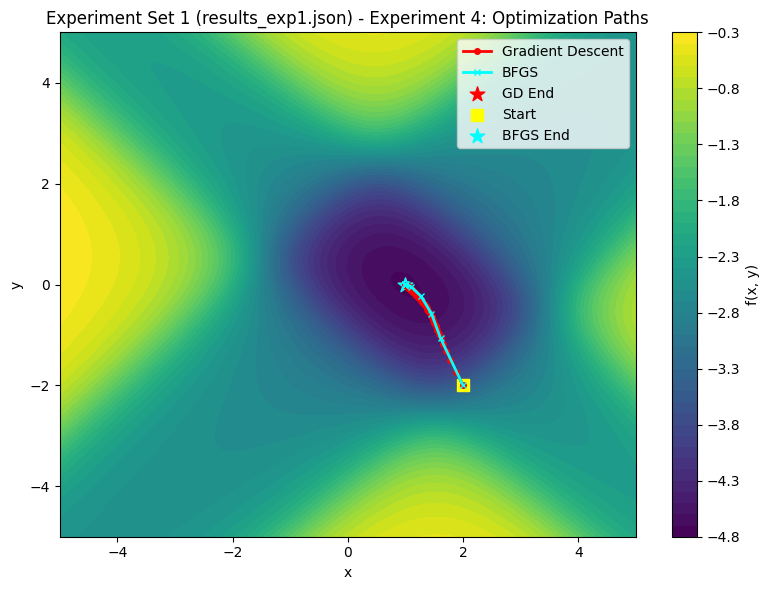

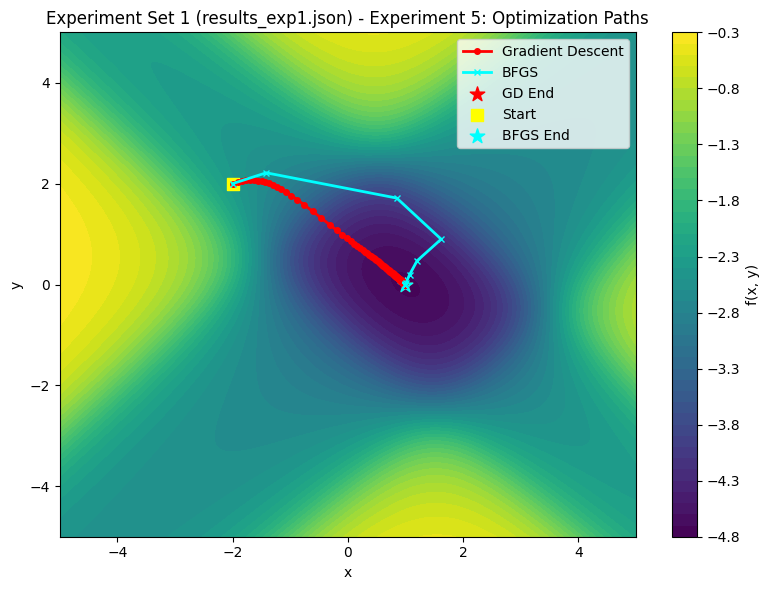

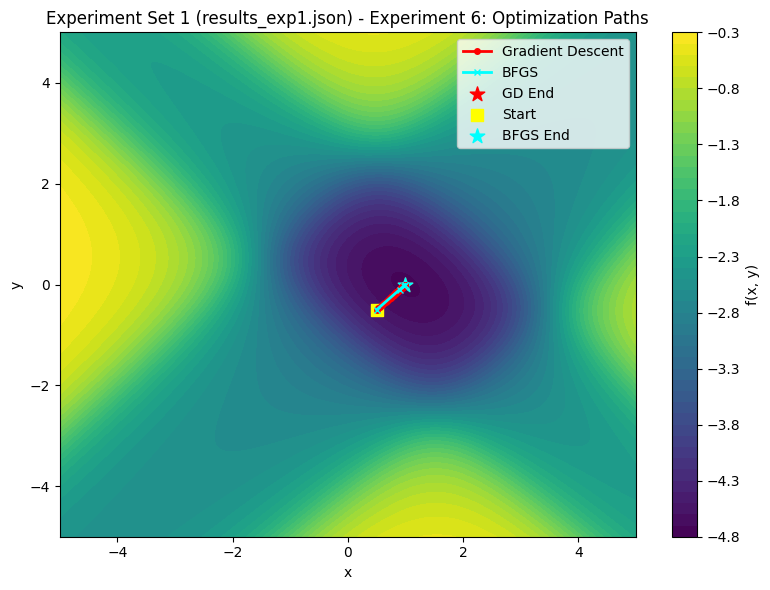

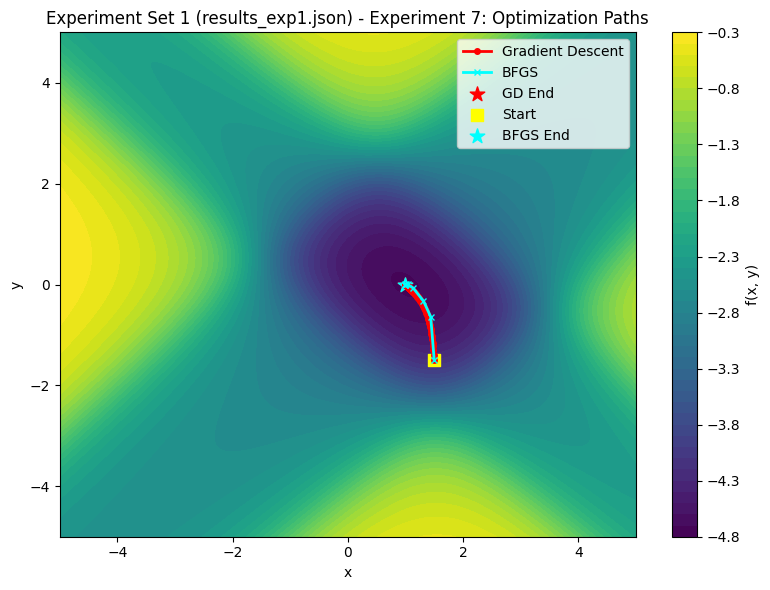

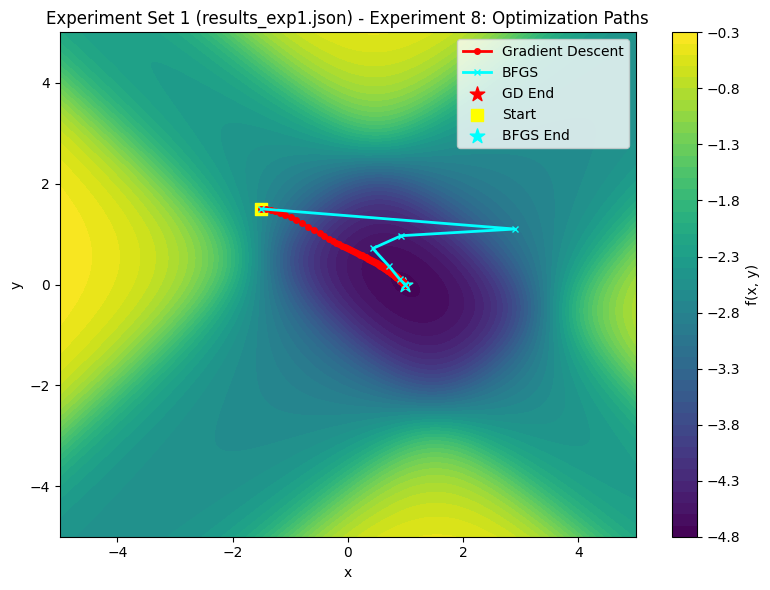

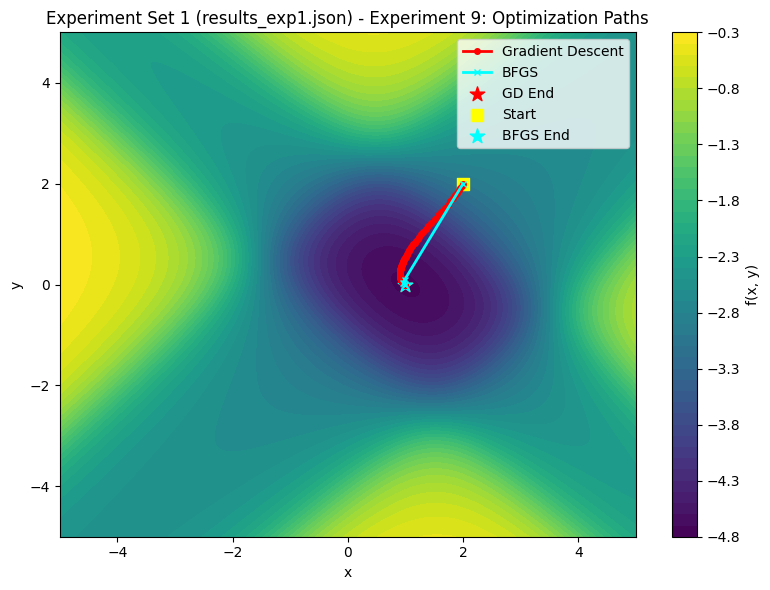

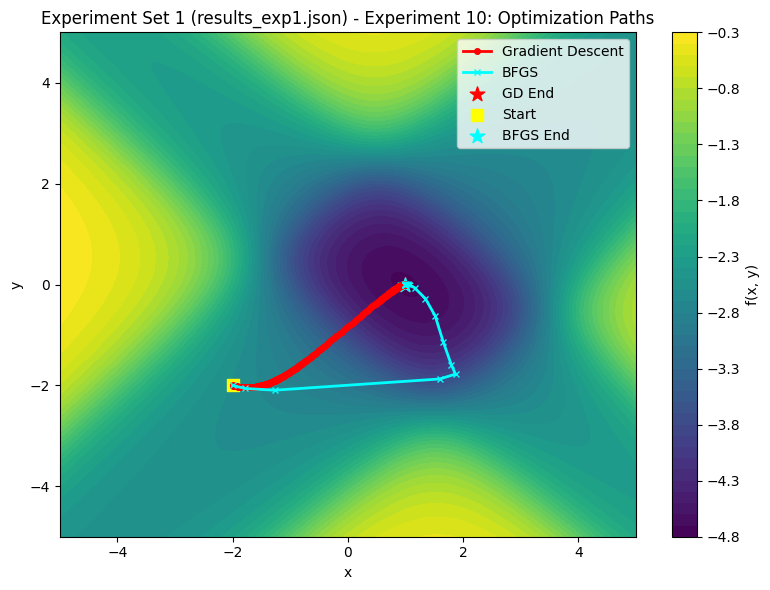

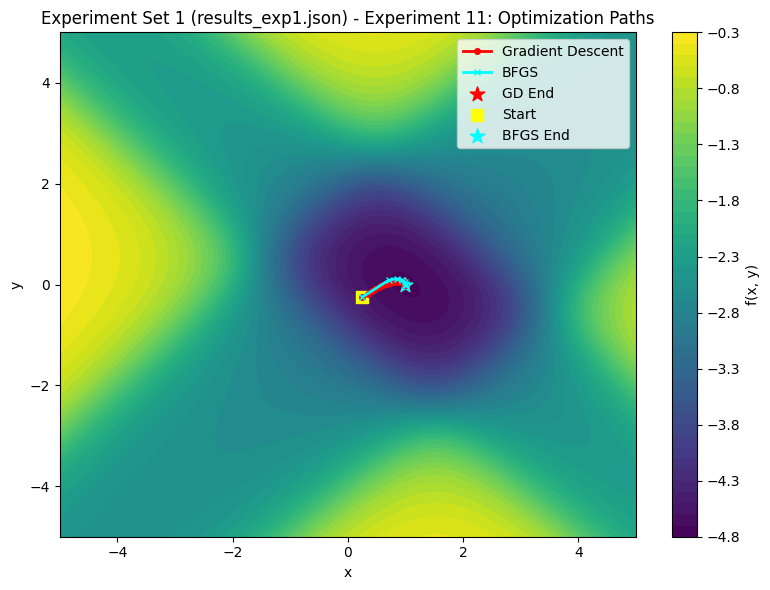

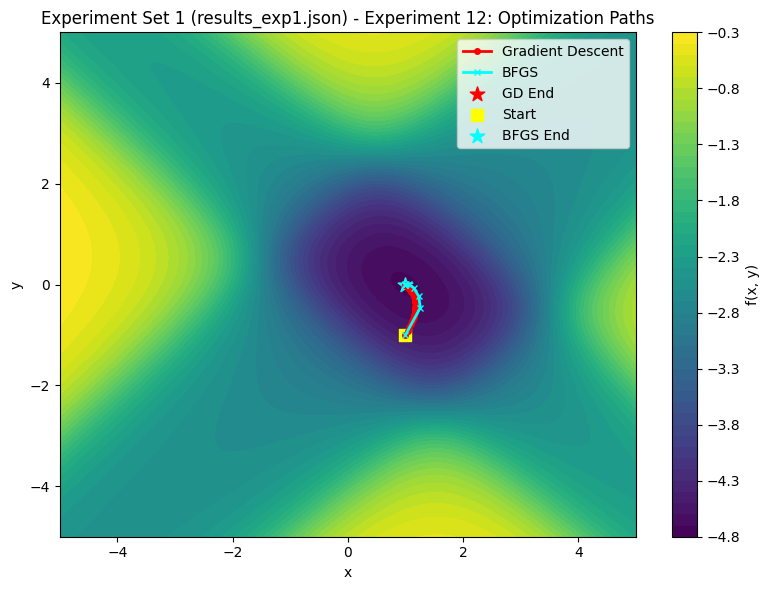

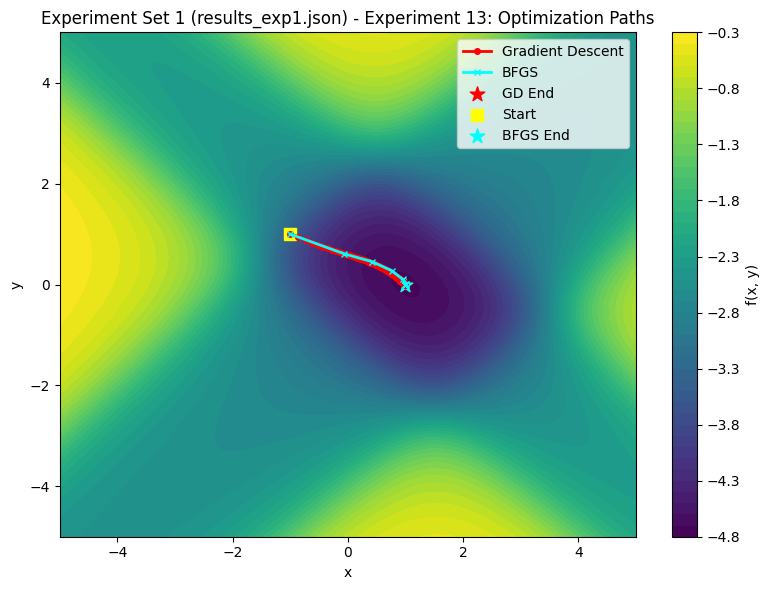

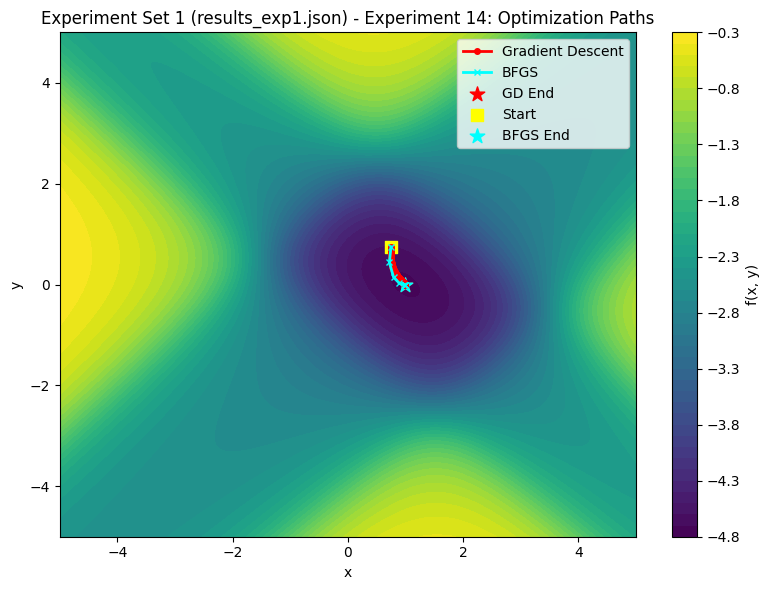

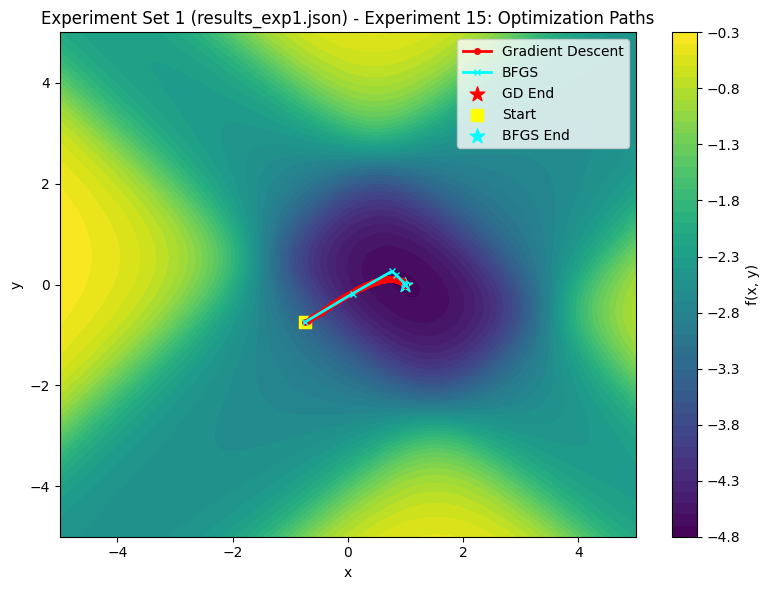

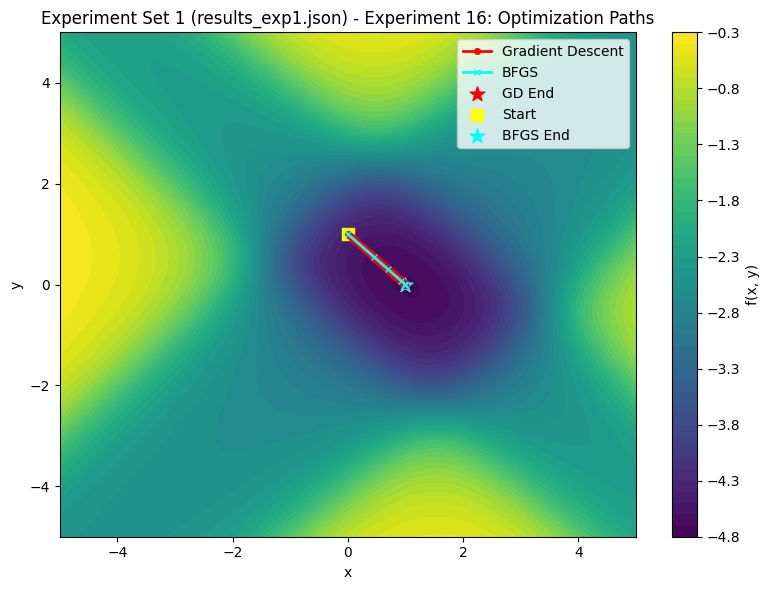

In [7]:
# Plot the paths of each experiment over a heatmap of the objective function for all experiment sets
import os
import json
import matplotlib.pyplot as plt
import numpy as np

results_dir = 'Results'
result_files = [f for f in os.listdir(results_dir) if f.startswith('results_') and f.endswith('.json')]

# Define the range for the heatmap
grid_points = 200
x_min, x_max = -5, 5
y_min, y_max = -5, 5
x = np.linspace(x_min, x_max, grid_points)
y = np.linspace(y_min, y_max, grid_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Compute the values of the objective function on the grid
for i in range(grid_points):
    for j in range(grid_points):
        Z[i, j] = f([X[i, j], Y[i, j]])

for file_idx, result_file in enumerate(sorted(result_files)):
    with open(os.path.join(results_dir, result_file), 'r') as fh:
        exp_results = json.load(fh)
    for idx, result in enumerate(exp_results):
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, Z, levels=50, cmap='viridis')
        plt.colorbar(label='f(x, y)')
        # Extract paths
        path_gd = np.array(result['gradient_descent']['path'])
        path_bfgs = np.array(result['bfgs']['path'])
        # Plot paths
        plt.plot(path_gd[:, 0], path_gd[:, 1], marker='o', color='red', label='Gradient Descent', linewidth=2, markersize=4)
        plt.plot(path_bfgs[:, 0], path_bfgs[:, 1], marker='x', color='cyan', label='BFGS', linewidth=2, markersize=4)
        # Mark start and end points
        plt.scatter(path_gd[-1, 0], path_gd[-1, 1], color='red', marker='*', s=120, label='GD End')
        plt.scatter(path_bfgs[0, 0], path_bfgs[0, 1], color='yellow', marker='s', s=80, label='Start')
        plt.scatter(path_bfgs[-1, 0], path_bfgs[-1, 1], color='cyan', marker='*', s=120, label='BFGS End')
        plt.title(f'Experiment Set {file_idx+1} ({result_file}) - Experiment {idx+1}: Optimization Paths')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

## Gráfica comparativas de las iteraciones y el tiempo transcurrido en la ejecución de los algoritmos

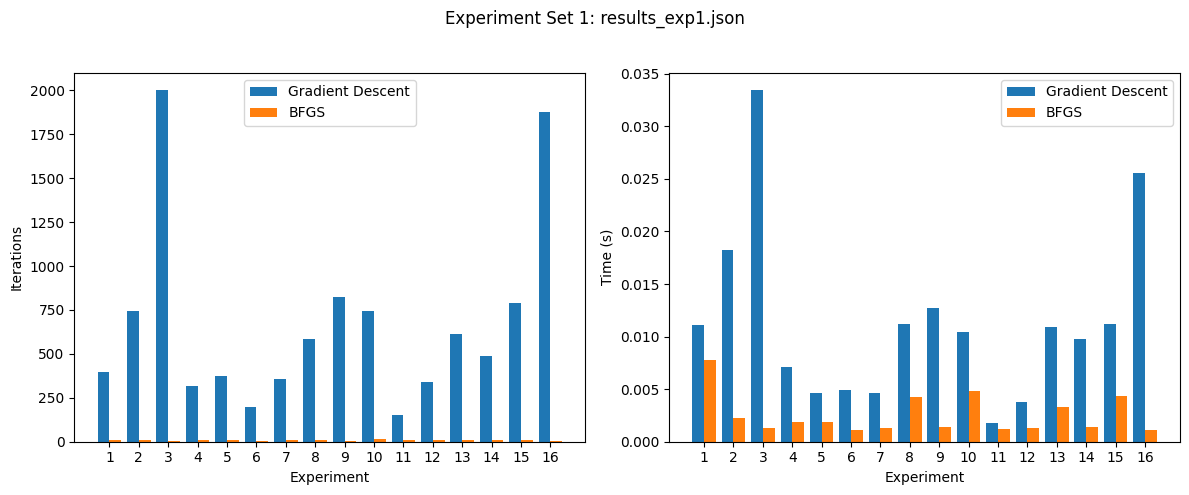

In [8]:
# Comparative bar plots for all experiment sets: iterations and time for each algorithm
import os
import json
import matplotlib.pyplot as plt
import numpy as np

results_dir = 'Results'
result_files = [f for f in os.listdir(results_dir) if f.startswith('results_') and f.endswith('.json')]

for file_idx, result_file in enumerate(sorted(result_files)):
    with open(os.path.join(results_dir, result_file), 'r') as fh:
        exp_results = json.load(fh)
    
    iterations_gd = [r['gradient_descent']['iterations'] for r in exp_results]
    iterations_bfgs = [r['bfgs']['iterations'] for r in exp_results]
    times_gd = [r['gradient_descent']['time'] for r in exp_results]
    times_bfgs = [r['bfgs']['time'] for r in exp_results]
    x_pos = np.arange(len(exp_results))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Experiment Set {file_idx+1}: {result_file}')
    # Iterations bar plot
    axes[0].bar(x_pos - 0.2, iterations_gd, 0.4, label='Gradient Descent')
    axes[0].bar(x_pos + 0.2, iterations_bfgs, 0.4, label='BFGS')
    axes[0].set_ylabel('Iterations')
    axes[0].set_xlabel('Experiment')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels([str(i+1) for i in x_pos])
    axes[0].legend()
    # Time bar plot
    axes[1].bar(x_pos - 0.2, times_gd, 0.4, label='Gradient Descent')
    axes[1].bar(x_pos + 0.2, times_bfgs, 0.4, label='BFGS')
    axes[1].set_ylabel('Time (s)')
    axes[1].set_xlabel('Experiment')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels([str(i+1) for i in x_pos])
    axes[1].legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()